# Metaplectic Geometrical Optics - Tracing Rays and Calculating Amplitude

## MGO Solution to Airy Problem

### Setup

In [1]:
import finite_diff as fd
import torch
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
import matplotlib as mpl
from scipy.integrate import solve_ivp, cumulative_trapezoid
from scipy.special import airy
from scipy.interpolate import LinearNDInterpolator
from scipy.signal import find_peaks

from trace_ray import trace_ray, get_t
from torch_helper import to_torch, to_torch_3D, torch_func, inner_product, angle

In [2]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

In [3]:
from skimage.segmentation import flood

def np_inner_product(a, b):
    return np.einsum('...i,...i->...', a, b)

def sgn_mask_from_seed(a, seed):
    '''returns boolean array mask for the "sign branch" connected to the seed index.
    A "sign branch" is here defined as a connected region where the sign of the array `a` is constant.
    '''
    return flood(np.signbit(a), seed)

def get_masks_of_const_sgn(a):
    '''returns list of boolean arrays with masks which
    subdivide the values of the array, `a`,
    into regions where the sign is constant.'''
    seed = (0, 0, 0)
    regions_remaining = True
    masks = []
    while regions_remaining:
        masks.append(sgn_mask_from_seed(a, seed))
        remaining_cells = np.argwhere(np.any(masks, axis=0) == False)
        if len(remaining_cells) > 0:
            seed = tuple(remaining_cells[0])
        else:
            regions_remaining = False
    return masks

In [4]:
@torch_func
def D(r: ('vector'), k: ('vector'), omega: ('scalar')):
    x, y, z = r
    return - x - inner_product(k, k)

### Exact Solution gives Initial Conditions

In [5]:
def Ai(x):
    ai, *_ = airy(x)
    return ai

def Bi(x):
    _, _, bi, _ = airy(x)
    return bi

x = np.linspace(-8, 0, 1000)
E_ex = Ai(x) # Exact solution is Airy function

# Set ICs from Airy function
first_peak_ind = find_peaks(E_ex)[0][0]
x0  = x[first_peak_ind]
phi0 = E_ex[first_peak_ind]

### Ray Tracing

In [6]:
n2, n3 = 4, 5
nt = 100

y0s = np.linspace(0, 1, n2)
z0s = np.linspace(0, 10, n3)

In [7]:
rs = np.zeros((nt, n2, n3, 3))
ks = np.zeros((nt, n2, n3, 3))
omega0 = 1.0
# ray tracing stops when it hits boundary, so we don't know
# exact number of timesteps before ray tracing has completed.
min_nt = nt

for i, y0 in enumerate(y0s):
    for j, z0 in enumerate(z0s):
        tau_ind = (i, j)
        sol = trace_ray(r0 = np.array([x0, y0, z0]), k0=np.array([np.sqrt(-x0), 0, 0]), omega0=omega0, tmin=0, tmax=8, D=D, r_min=np.array([x0, 0, 0]), tsteps=nt)
        sol_nt = len(sol.t)
        rs[:sol_nt, i, j, :] = sol.y[:3].T
        ks[:sol_nt, i, j, :] = sol.y[3:].T
        min_nt = np.min((sol_nt, min_nt))

# Clip all rays to the same number of time steps
nt = min_nt
t = sol.t[:min_nt]
rs = rs[:min_nt, :, :, :]
ks = ks[:min_nt, :, :, :]

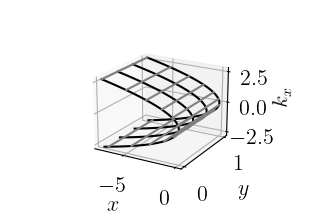

In [8]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(projection='3d')
for i, y0 in enumerate(y0s):
    ax.plot(rs[:, i, 0, 0], rs[:, i, 0, 1], ks[:, i, 0, 0], 'k-')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$k_x$')
for i in range(0, len(t), int(len(t)/10)):
    ax.plot(rs[i, :, 0, 0], rs[i, :, 0, 1], ks[i, :, 0, 0], '-', color='grey')
ax.view_init(20, -60, 0)
plt.tight_layout()
plt.savefig('./plots/GO_airy_dispersion_manifold.png')
plt.savefig('./plots/GO_airy_dispersion_manifold.pdf')
fig.add_axes([0,0,1,1]).axis("off")
plt.show()

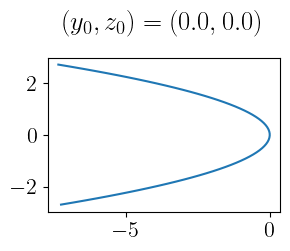

In [9]:
i, j = (0, 0)
plt.figure(figsize=(3,2))
plt.plot(rs[:, 0, 0, 0], ks[:, 0, 0, 0])
plt.title(r'$(y_0, z_0) = (' + str(round(y0s[i], 2)) + ', ' + str(round(z0s[j], 2)) + ')$')
plt.show()

### MGO Part

**Note**: In this numerical implementation, the vector quantities $r$, $k$ (the variables `rs`, `ks` in the code) are written as row vectors such that they have 3 as their last dimension, and $z=(r, k)$ (the variable `zs` in the code) has 6 as its' last dimension. Thus, the last axis is transposed when compared to Lopez' derivations. However, for convenience, I've chosen to write all matrices from the Lopez-article with the usual shaping. I.e: I have chosen **not** to transpose the matrices. For instance, each *column* in $S^{-1}$ corresponds to either a tangent or normal vector of the dispersion manifold.

In [10]:
# A = np.arange(4*3*2*2).reshape(4, 3, 2, 2)
# A[0, 0], A[1, 0], A[2, 2]
# A[..., 0].shape
# A[..., 0], np_inner_product(A[..., 0], A[..., 0])

In [11]:
def gram_schmidt_orthogonalize(Q):
    N = Q.shape[-1]
    P = np.zeros(Q.shape)

    def norm(A, i):
        norms = np.sqrt(np_inner_product(A[..., i], A[..., i]))
        return np.stack([norms]*A.shape[-1], axis=-1)

    P[..., 0] = Q[..., 0]/norm(Q, 0)
    for k in range(1, N):
        P[..., k] = (Q[..., k]
                        - sum([(
            np.stack([np_inner_product(Q[..., k], P[..., j])]*N, axis=-1)
            ) * P[..., j] for j in range(k)]))
        P[..., k] = P[..., k]/norm(P, k)
    return P

In [12]:
ND = rs.shape[-1]
zs = np.concatenate((rs, ks), axis=-1)
gradt_z = fd.grad(zs, t)
norms = np.sqrt(np_inner_product(gradt_z, gradt_z))
T1 = gradt_z/np.stack([norms]*zs.shape[-1], axis=-1) # normalised grad_t z(t, y0, z0)

# For each tau, create an identity matrix
eye = np.zeros(np.prod(zs.shape)*zs.shape[-1]).reshape((*zs.shape, zs.shape[-1]))
eye[..., :, :] = np.eye(zs.shape[-1])

# For each tau, create orthonormal basis starting from
# single tangent vector using Gram Schmidt orthogonalization
ONB = np.copy(eye)
ONB[..., 0] = T1
ONB = gram_schmidt_orthogonalize(ONB)

# Tangent space is first 3 vectors of basis:
# Note: Basis vectors in T are shaped as columns!
T = ONB[..., :ND]

In [21]:
symplJ = np.copy(ONB)
symplJ[..., :, :] =  np.block([
    [  np.zeros((ND, ND)),  np.eye((ND))        ],
    [  -np.eye(ND),         np.zeros((ND, ND))  ]])

def np_transpose(A):
    '''return transpose of only the last two dimensions.'''
    return np.moveaxis(A, -1, -2)

N = -np.matmul(symplJ, T)
R = np.concatenate((T, N), axis=-1)
S = np_transpose(R)
gradt_S = fd.grad(S, t)

In [14]:
# print(
#     'sample tests of matrices',
#     '\n\n T^T T \n',
#     np.matmul(np_transpose(T), T)[0:3, 0, 0],
#     '\n\n N^T N \n',
#     np.matmul(np_transpose(N), N)[0:3, 0, 0],
#     '\n\n N^T J T \n',
#     np.matmul(np_transpose(N), np.matmul(symplJ, T))[0:3, 0, 0],
#     '\n\n T^T J T \n',
#     np.round(np.matmul(np_transpose(T), np.matmul(symplJ, T))[0:3, 0, 0], 4),
# )

#### Digression: Inspection of Tangent and Normal Vectors

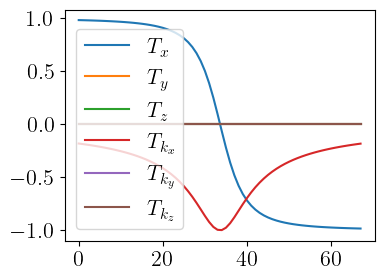

In [15]:
plt.figure(figsize=(4,3))
plt.plot(T[:, 0, 0, :, 0])
plt.legend([r'$T_{x}$', r'$T_{y}$', r'$T_{z}$', r'$T_{k_x}$', r'$T_{k_y}$', r'$T_{k_z}$'])
plt.show()

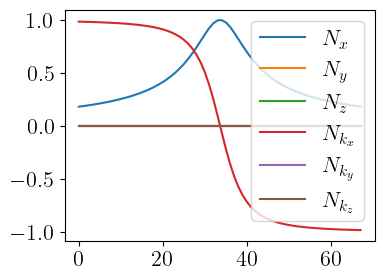

In [16]:
plt.figure(figsize=(4,3))
plt.plot(N[:, 0, 0, :, 0])
plt.legend([r'$N_{x}$', r'$N_{y}$', r'$N_{z}$', r'$N_{k_x}$', r'$N_{k_y}$', r'$N_{k_z}$'])
plt.show()

Comparison with Lopez Expressions:

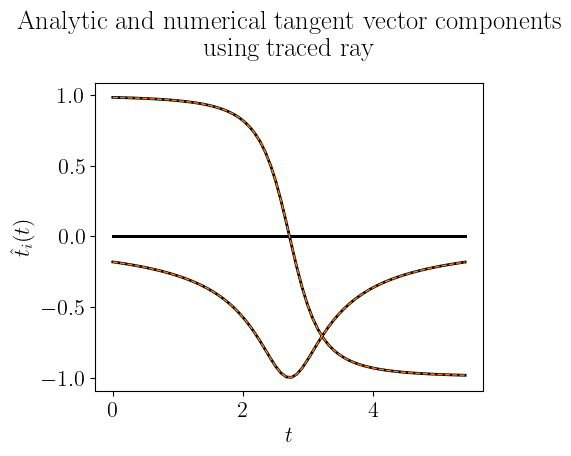

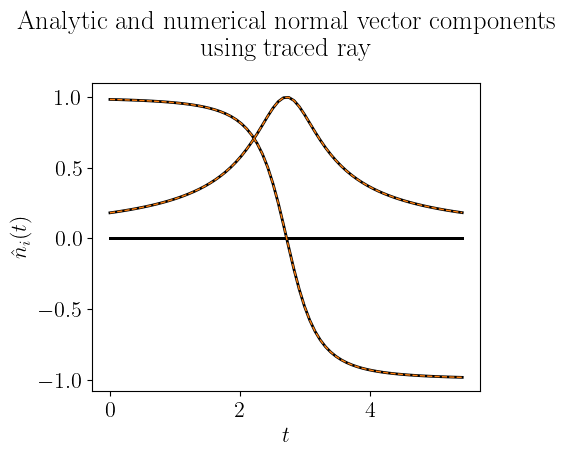

In [17]:
v_ex = np.sqrt(1+4*(ks[..., 0]**2))
T_ex = np.stack([ 1/v_ex * 2*ks[..., 0], -1/v_ex * np.ones_like(ks[..., 0])], axis=-1) # tangent matrix from Lopez example
N_ex = np.stack([ 1/v_ex * np.ones_like(ks[..., 0]), 1/v_ex * 2*ks[..., 0] ], axis=-1)

plt.figure(figsize=(5,4))
plt.plot(t, T[:, 0, 0, :, 0], '-', color='black', linewidth=2, label='approx')
plt.plot(t, T_ex[:, 0, 0, :], '--', color='tab:orange', linewidth=1, label='exact')
plt.xlabel(r'$t$')
plt.ylabel(r'$\hat{t}_i(t)$')
plt.title('Analytic and numerical tangent vector components \n using traced ray')
plt.show()

plt.figure(figsize=(5,4))
plt.plot(t, N[:, 0, 0, :, 0], '-', color='black', linewidth=2, label='approx')
plt.plot(t, N_ex[:, 0, 0, :], '--', color='tab:orange', linewidth=1, label='exact')
plt.xlabel(r'$t$')
plt.ylabel(r'$\hat{n}_i(t)$')
plt.title('Analytic and numerical normal vector components \n using traced ray')
plt.show()

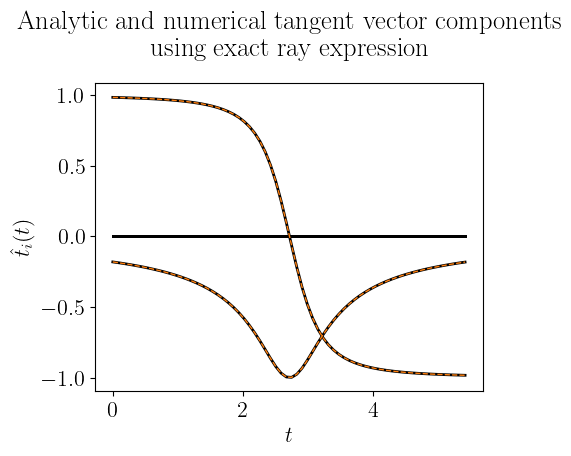

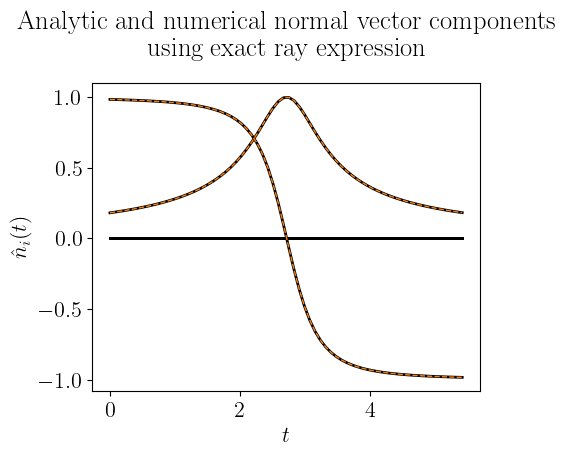

In [18]:
ks_ex = np.apply_along_axis(lambda x: x - t, axis=0, arr=np.ones_like(ks[..., 0]) * ks[0, ..., 0])
v_exx = np.sqrt(1+4*(ks_ex**2))
T_exx = np.stack([ 1/v_ex * 2*ks_ex, -1/v_ex * np.ones_like(ks_ex)], axis=-1) # tangent matrix from Lopez example
N_exx = np.stack([ 1/v_ex * np.ones_like(ks_ex), 1/v_ex * 2*ks_ex], axis=-1)

plt.figure(figsize=(5,4))
plt.plot(t, T[:, 0, 0, :, 0], '-', color='black', linewidth=2, label='approx')
plt.plot(t, T_exx[:, 0, 0, :], '--', color='tab:orange', linewidth=1, label='exact')
plt.xlabel(r'$t$')
plt.ylabel(r'$\hat{t}_i(t)$')
plt.title('Analytic and numerical tangent vector components \n using exact ray expression')
plt.show()

plt.figure(figsize=(5,4))
plt.plot(t, N[:, 0, 0, :, 0], '-', color='black', linewidth=2, label='approx')
plt.plot(t, N_exx[:, 0, 0, :], '--', color='tab:orange', linewidth=1, label='exact')
plt.xlabel(r'$t$')
plt.ylabel(r'$\hat{n}_i(t)$')
plt.title('Analytic and numerical normal vector components \n using exact ray expression')
plt.show()

Animation of tangent and normal planes

In [81]:
def line_2d_from_normal(n, r0, x):
    nx, ny = n
    x0, y0 = r0

    if np.isclose(ny, 0):
        return np.array([x0, x0]), np.array(plt.gca().get_ylim())
    else:
        return x, y0 - nx/ny*(x-x0)

t2d = np.stack([T[:, 0, 0, 0, 0], T[:, 0, 0, ND, 0]], axis=-1)
n2d = np.stack([N[:, 0, 0, 0, 0], N[:, 0, 0, ND, 0]], axis=-1)
z2d = np.stack([rs[:, 0, 0, 0], ks[:, 0, 0, 0]], axis=-1)

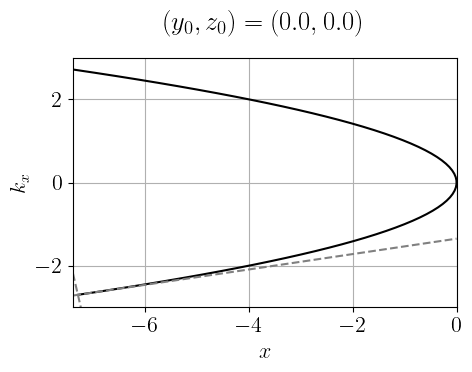

In [82]:

from matplotlib import animation

i, j = (0, 0)
fig = plt.figure(figsize=(5,4))
plt.plot(rs[:, i, j, 0], ks[:, i, j, 0], 'k-')
plt.title(r'$(y_0, z_0) = (' + str(round(y0s[i], 2)) + ', ' + str(round(z0s[j], 2)) + ')$')
plt.xlim(np.min(rs[:, i, j, 0]), 0)
plt.ylim(-3, 3)
plt.grid()
plt.xlabel(r'$x$')
plt.ylabel(r'$k_x$')
tangent = plt.plot(*line_2d_from_normal(n2d[0], z2d[0], x), '--', color='grey')[0]
normal = plt.plot(*line_2d_from_normal(t2d[0], z2d[0], x), '--', color='grey')[0]

def update(frame):
    x_tan, y_tan = line_2d_from_normal(n2d[frame], z2d[frame], x)
    tangent.set_xdata(x_tan)
    tangent.set_ydata(y_tan)

    x_nor, y_nor = line_2d_from_normal(t2d[frame], z2d[frame], x)
    normal.set_xdata(x_nor)
    normal.set_ydata(y_nor)
    return tangent, normal

plt.tight_layout()
anim = animation.FuncAnimation(fig=fig, func=update, frames=rs.shape[0], blit=True)
anim.save('./plots/MGO_tangent_animation_1d_nt_' + str(nt) + '.gif', fps=int(rs.shape[0]/20), dpi=300)

In [83]:
np_inner_product(n2d, t2d)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

#### Back on track

In [22]:
def neighbourhood(i, N, N_neighbours=1):
    '''returns slice corresponding to neighbourhood of i
        and index of i in sliced array.'''
    if i < 0 or i >= N:
        raise ValueError('index for neighbourhood is out of bounds')
    if i - N_neighbours < 0:
        return slice(min(1+2*N_neighbours, N)), i
    if i + N_neighbours >= N:
        return slice(max(0, N-(1+2*N_neighbours)), N), - (N-i)
    return slice(i - N_neighbours, i + N_neighbours + 1), N_neighbours

In [23]:
alpha_0 = 1 # (-0.2595+0.3372j)

for i2, iy0 in enumerate(y0s):
    for i3, z0 in enumerate(z0s):
        # Initialization for t = 0
        nbh_slice0, nbh_i0 = neighbourhood(0, nt)
        S_t = S[nbh_slice0, i2, i3]
        Zs_t = np.zeros((S_t.shape[0], *zs.shape))
        for nbh_i, S_t0 in enumerate(S_t):
            Zs_t[nbh_i, ...] = np.matmul(S_t0, zs[..., np.newaxis]).squeeze()
        
        eta_t = np.zeros(nt, dtype=np.complex128)

        for i1, t0 in enumerate(t):
            # Set quantities for neighbouring times. The position for neighbouring times
            # is needed to calculate the total derivative in time which accounts for both
            # the change in position with time and the change in the symplectic transform.
            nbh_slice, nbh_i = neighbourhood(i1, nt)
            t_nbh = t[nbh_slice]
            S_t = S[nbh_slice, i2, i3]
            Zs_t[-1, ...] = np.matmul(S_t[-1], zs[..., np.newaxis]).squeeze()      
            Rs_t = Zs_t[..., :ND]
            
            # GO on tangent plane. Calculate Field in rotated phase space.
            S_t0 = S_t[nbh_i]
            Zs_t0 = Zs_t[nbh_i]
            Rs_t0 = Zs_t0[..., :ND]
            Ks_t0 = Zs_t0[..., ND:]
            gradt_Rs_t0 = fd.grad(Rs_t0, t)
            Theta0 = 0
            Theta_t0 = Theta0 + cumulative_trapezoid(np_inner_product(Ks_t0, gradt_Rs_t0), t, initial=0, axis=0)
            J_t0 = np.linalg.det(fd.grad(Rs_t0, t, y0s, z0s))
            Phi_t0 = np.emath.sqrt(J_t0[i1, ...]/J_t0) # Amplitude set to 1 at tau = t (time index i1)
            mask_t0 = sgn_mask_from_seed(J_t0, (i1, i2, i3)) # get current branch
            Field_t0 = np.real(Phi_t0*np.exp(1j*Theta_t0) * mask_t0) # only include contribution from current branch
            
            # Calculate eta_t needed for amplitude factor, alpha_t
            dS = gradt_S[i1, i2, i3] @ np.linalg.inv(S_t0)
            W_t0, U_t0, V_t0 = dS[:ND,ND:], -dS[ND:,:ND], -dS[ND:, ND:]
            # # # Uncomment to print errors of U, W compared to the analytical expression
            # print('error on U, W: ',
            #       np.round(np.abs(- 2/(v_ex[i1, 0, 0]**2) -  W_t0[0, 0]), 4),
            #       np.round(np.abs(- 2/(v_ex[i1, 0, 0]**2) -  U_t0[0, 0]), 4))

            gradh_R = np.sum(
                fd.grad(Rs_t[:, nbh_slice, i2, i3, ...], t_nbh, t_nbh)[nbh_i, nbh_i, ...],
                axis=-1)
            gradR_phi = np.array([fd.grad(Phi_t0[nbh_slice, i2, i3], Rs_t0[nbh_slice, i2, i3][..., i])[nbh_i] for i in range(ND)])
            eta_t[i1] = (
                (gradh_R - V_t0 @ Rs_t0[i1, i2, i3] - W_t0 @ Ks_t0[i1, i2, i3]).T @
                (gradR_phi + 1j * Ks_t0[i1, i2, i3])
                - (1/2) * np.trace(V_t0)
                - 1j * ( Rs_t0[i1, i2, i3].T @ U_t0 @ Rs_t0[i1, i2, i3] )
                + (1j/2) * ( Ks_t0[i1, i2, i3].T @ W_t0 @ Ks_t0[i1, i2, i3] )
            )
            
            # Prepare for next calculation
            Zs_t = np.roll(Zs_t, shift=-1, axis=0)
        
        alpha_t = alpha_0 * np.exp(cumulative_trapezoid(eta_t, t, initial=0))

#### Digression: Comparison of exact $\eta, \alpha$ vs. approximate values

In [218]:
eta_t_ex = (2*ks_ex/(v_ex**2)
              + 1j*(
                  (20*(ks_ex**6) + 11*(ks_ex**4) + 2*(ks_ex**2))
                  / ( v_ex**4 )))
alpha_t_ex = np.exp(- np.log(np.sqrt(v_ex))
              - 1j * (2*ks_ex**3 / 3)
              + 1j * (ks_ex**5 / (v_ex**2)))

# alpha_t_ex = (1/np.sqrt(v_ex)) * np.exp( - 1j * (2*ks_ex**3 / 3) + 1j * (ks_ex**5 / (v_ex**2)))

In [219]:
np.conj(alpha_t_ex[0, 0, 0] / alpha_t[0])

(-0.2595232507399009+0.3372161288258308j)

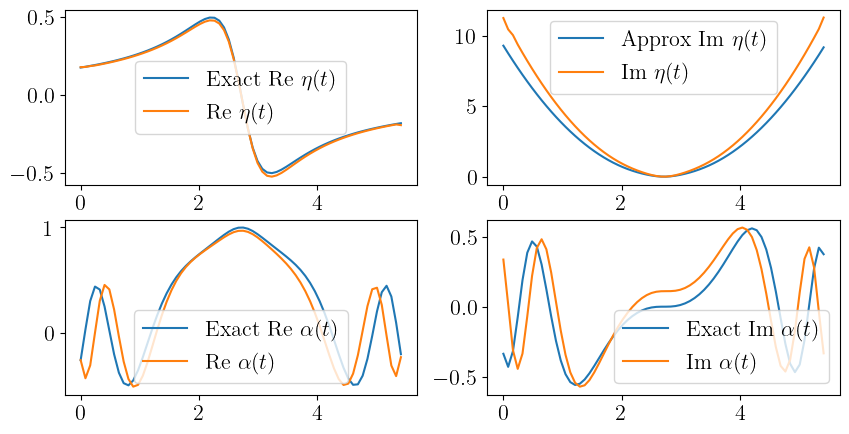

In [220]:
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
axes[0, 0].plot(t, np.real(eta_t_ex[:, 0, 0]), label=r'Exact Re $\eta(t)$')
axes[0, 0].plot(t, np.real(eta_t), label=r'Re $\eta(t)$')
axes[0, 0].legend()

axes[0, 1].plot(t, np.imag(eta_t_ex[:, 0, 0]), label=r'Approx Im $\eta(t)$')
axes[0, 1].plot(t, np.imag(eta_t), label=r'Im $\eta(t)$')
axes[0, 1].legend()

axes[1, 0].plot(t, np.real(alpha_t_ex[:, 0, 0]), label=r'Exact Re $\alpha(t)$')
axes[1, 0].plot(t, np.real(alpha_t * np.conj(alpha_t_ex[0, 0, 0] / alpha_t[0])), label=r'Re $\alpha(t)$')
axes[1, 0].legend()

axes[1, 1].plot(t, np.imag(alpha_t_ex[:, 0, 0]), label=r'Exact Im $\alpha(t)$')
axes[1, 1].plot(t, np.imag(alpha_t * np.conj(alpha_t_ex[0, 0, 0] / alpha_t[0])), label=r'Im $\alpha(t)$')
axes[1, 1].legend()
plt.show()

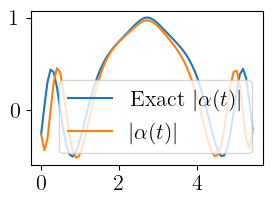

In [221]:
plt.figure(figsize=(3, 2))
plt.plot(t, np.real(alpha_t_ex[:, 0, 0]), label=r'Exact $|\alpha(t)|$')
plt.plot(t, np.real(alpha_t * np.conj(alpha_t_ex[0, 0, 0] / alpha_t[0])), label=r'$|\alpha(t)|$')
plt.legend()
plt.show()

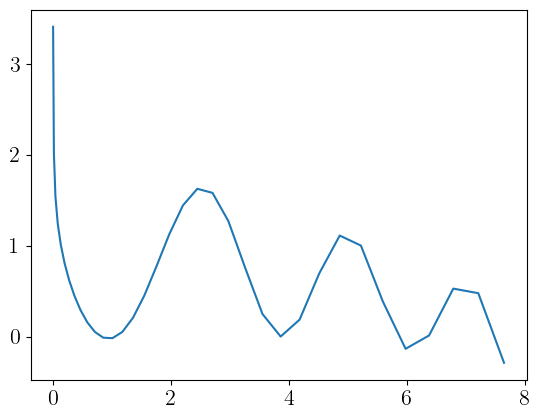

In [24]:
plt.plot(Rs_t0[:,0,0,0][Field_t0[:,0,0] != 0], np.real((alpha_t * Field_t0[:,0,0])[Field_t0[:,0,0] != 0]))
# plt.plot(Rs_t0[:,0,0,0], np.imag(Field_t0[:,0,0]))

#### Back on Track

In [25]:
def G1(r, R, S):
    _r, _R = r[..., np.newaxis], R[..., np.newaxis]
    A, B, C, D = S[..., :ND, :ND], S[..., :ND, ND:], S[..., ND:, :ND], S[..., ND:, ND:]
    return (
        np_transpose(_r) @ np.linalg.inv(B) @ (1/2 * A @ _r - _R)
        + 1/2 * np_transpose(_R) @ D @ np.linalg.inv(B) @ _R
    )